In [1]:
# In case you want to change the deepxde default backend just run the following line and select the backend at the end of the line:
# source: https://www.kaggle.com/code/lucasscheink/tesis-2d

# !python /Users/vassilis/anaconda3/pkgs/deepxde-1.9.3-pyhd5b0024_0/site-packages/deepxde/backend/set_default_backend.py tensorflow

In [2]:
import deepxde as dde
import numpy as np
import pandas as pd
import scipy as sp
from math import exp
#import tensorflow as tf
from deepxde.backend import tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import os
import re

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [3]:
os.getcwd()

'/Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation'

Here we define the parameters that we want to estimate.

In [4]:
# Parameters to be estimated.

P_liver = dde.Variable(0.5)
P_muscle = dde.Variable(0.5)
P_kidney = dde.Variable(0.5)
P_skin = dde.Variable(0.5)
P_gills = dde.Variable(0.5)
P_carcass = dde.Variable(0.5)
P_viscera = dde.Variable(0.5)

Now we can begin by creating a TimeDomain class.

In [5]:
geom = dde.geometry.TimeDomain(0, 56*24)

In [6]:
# Function to estimate the constant parameters of the model
def create_params(substance, Texp):
    # Transform input temperature into Kelvin scale
    Texp = 273 + Texp  # K

    Tref = 273 + np.array([6, 12, 18])  # Reference Temperature K - Grech et al. 2018
    keep_ref_value = np.argmin(np.abs(Tref - Texp))

    # Cardiac output reference value at T = 6 C (Barron et al. 1987, Table II)
    F_card_ref_6 = 1.188  # ml/h/g
    # Cardiac output reference value at T = 12 C (Barron et al. 1987, Table II)
    F_card_ref_12 = 2.322  # ml/h/g
    # Cardiac output reference value at T = 18 C (Barron et al. 1987, Table II)
    F_card_ref_18 = 3.75  # ml/h/g
    F_card_ref_values = [F_card_ref_6, F_card_ref_12, F_card_ref_18]
    F_card_ref = F_card_ref_values[keep_ref_value]

    # Body weight reference value at T = 6 C (Barron et al. 1987, Table II)
    BW_ref_6 = 270.1  # g
    # Body weight reference value at T = 12 C (Barron et al. 1987, Table II)
    BW_ref_12 = 296.4  # g
    # Body weight reference value at T = 18 C (Barron et al. 1987, Table II)
    BW_ref_18 = 414.5  # g
    BW_ref_values = [BW_ref_6, BW_ref_12, BW_ref_18]
    BW_ref = BW_ref_values[keep_ref_value]

    # Arrhenius Temperature function
    TA = 6930  # Arrhenius Temperature K - Grech et al. 2018
    Tr = Tref[np.argmin(np.abs(Tref - Texp))]
    KT = exp(TA / Tr - TA / Texp)

    # Load the xlsx file with the physiological params of rainbow trout
    phys_params_sheet1 = pd.read_excel('/Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/Rainbow trout Physiological parameters/Rainbow trout Physiological parameters.xlsx', sheet_name=0)

    # Keep only the physiological parameters from the paper of Vidal et al. 2019
    fw = phys_params_sheet1.loc[phys_params_sheet1['Source'] == 'Vidal et al. 2019', ['Liver', 'Blood', 'Skin', 'Muscle', 'Gills', 'Kidney', 'Viscera']]
    fw_Liver = fw['Liver'].values[0]
    fw_Blood = fw['Blood'].values[0]
    fw_Skin = fw['Skin'].values[0]
    fw_Muscle = fw['Muscle'].values[0]
    fw_Gills = fw['Gills'].values[0]
    fw_Kidney = fw['Kidney'].values[0]
    fw_Viscera = fw['Viscera'].values[0]
    fw_lumen = 0.012

    # Load the xlsx file with the physiological params of rainbow trout
    phys_params_sheet2 = pd.read_excel('/Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/Rainbow trout Physiological parameters/Rainbow trout Physiological parameters.xlsx', sheet_name=1)

    # Keep only the physiological parameters from the paper of Vidal et al. 2019
    fb = phys_params_sheet2.loc[phys_params_sheet2['Source'] == 'Vidal et al. 2019', ['Liver', 'Skin', 'Muscle', 'Gills', 'Kidney', 'Viscera']]
    fb_Liver = fb['Liver'].values[0]
    fb_Skin = fb['Skin'].values[0]
    fb_Muscle = fb['Muscle'].values[0]
    fb_Gills = fb['Gills'].values[0]
    fb_Kidney = fb['Kidney'].values[0]
    fb_Viscera = fb['Viscera'].values[0]

    # Reabsorption coefficients from bile to intestine
    # estimated by Cao et al., 2022
    # K_urine = Cl_urine / f_reab_urine estimated by Ng et al., 2013 (unitless)
    if substance == 'PFOA':
        a = 0.138  # Sun et al., 2022, Goeritz et al. 2013
        f_reab_hep = 0.30  # Cao et al., 2022
        K_urine = 2.08
        Cl_urine = 0.029 * 3600  # 1/h (Sun et al., 2022)
    elif substance == 'PFNA':
        a = 0.522  # Sun et al., 2022, Goeritz et al. 2013
        f_reab_hep = 0.34  # Cao et al., 2022
        K_urine = 1.35
        Cl_urine = 0.050 * 3600  # 1/h (Sun et al., 2022)
    elif substance == 'PFBS':
        a = 0.0598  # Goeritz et al. 2013
        f_reab_hep = 0.23  # Cao et al., 2022
        K_urine = 5.88
        Cl_urine = 0.023 * 3600  # 1/h (Sun et al., 2022) # Assumed equal to PFHxS
    elif substance == 'PFHxS':
        a = 0.558  # Sun et al., 2022, Goeritz et al. 2013
        f_reab_hep = 0.30  # Cao et al., 2022
        K_urine = 5.88
        Cl_urine = 0.023 * 3600  # 1/h (Sun et al., 2022)
    elif substance == 'PFOS':
        a = 0.721  # Sun et al., 2022, Goeritz et al. 2013
        f_reab_hep = 0.42  # Cao et al., 2022
        K_urine = 1.35
        Cl_urine = 0.050 * 3600  # 1/h (Sun et al., 2022)

    # Bile flow coefficient
    Q_bile_coef = 7.5e-05  # ml/g BW/h Grosell et al., 2000
    Q_urine_coef = 2.755e-03  # ml/h/g of BW Urinary flow rate (Curtis et al., 1981)
    V_urine_coef = 2.2e-03  # ml/g of BW Urine volume inside urinary bladder (Curtis et al., 1981)

    a_skin = 0.9  # 90% of venous blood of skin was assumed to flow directly to kidney (Nichols et al. 1996)
    a_muscle = 0.6  # 60% of venous blood of muscle was assumed to flow directly to kidney (Nichols et al. 1996)

    plasma = 0.7
    
    return[F_card_ref, BW_ref, KT, fw_Liver, fw_Blood, fw_Skin, fw_Muscle, fw_Gills, fw_Kidney,
          fw_Viscera, fw_lumen, fb_Liver, fb_Skin, fb_Muscle, fb_Gills, fb_Kidney, fb_Viscera,
          a_skin, a_muscle, Q_bile_coef, Q_urine_coef, V_urine_coef, 
          K_urine, Cl_urine, f_reab_hep,plasma,a]

In [7]:
def fish_weight(time):
    x = tf.constant([0, 28 * 24, 56 * 24], dtype=tf.float32)
    y = tf.constant([314, 655, 808], dtype=tf.float32)

    w = tf.zeros([1,1])

    for time_i in tf.unstack(time):
        time_i = tf.cast(time_i, 'float32')
        condition_1 = tf.math.less_equal(time_i, tf.cast(x[0], 'float32'))
        condition_2 = tf.math.greater_equal(time_i, tf.cast(x[2], 'float32'))
        condition_3 = tf.math.logical_and(tf.math.greater_equal(time_i, tf.cast(x[0], 'float32')), tf.math.less(time_i, tf.cast(x[1], 'float32')))
        condition_4 = tf.math.logical_and(tf.math.greater_equal(time_i, tf.cast(x[1], 'float32')), tf.math.less(time_i, tf.cast(x[2], 'float32')))
        
        w_new = tf.cond(condition_1, lambda: y[0], 
                         lambda: tf.cond(condition_2, lambda: y[2], 
                                         lambda: tf.cond(condition_3, 
                                                         lambda: tfp.math.interp_regular_1d_grid(tf.cast(time_i, 'float32'), tf.cast(x[0], 'float32'),  
                                                                 tf.cast(x[1], 'float32'), tf.cast(y[0:2], 'float32')), 
                                                         lambda: tfp.math.interp_regular_1d_grid(tf.cast(time_i, 'float32'), tf.cast(x[1], 'float32'), 
                                                                    tf.cast(x[2], 'float32'), tf.cast(y[1:3], 'float32')) ))) 
        
        w_new = tf.reshape(w_new, [-1,1])
        w = tf.concat([w, w_new], axis=0)   
    w = w[1:]
    return (w)

Next, we create the PBK model to solve using the dde.grad.jacobian function.

In [8]:
def PBK_model(t, net_out, ex):
    # At this point we estimate the derivatives of the networks outputs to time    
    M_art, M_venous, M_gills, M_lumen, M_lumen_2, M_viscera, M_liver, M_kidney, \
    M_muscle, M_skin, M_carcass, M_storage, M_urine, M_feces, M_blood = net_out[:, 0:1], net_out[:, 1:2], \
    net_out[:, 2:3], net_out[:, 3:4], net_out[:, 4:5], net_out[:, 5:6], net_out[:, 6:7], net_out[:, 7:8], \
    net_out[:, 8:9], net_out[:, 9:10], net_out[:, 10:11], net_out[:, 11:12], net_out[:, 12:13], net_out[:, 13:14], net_out[:, 14:15]
    
    dM_art_ls = dde.gradients.jacobian(net_out, t, i=0)
    dM_venous_ls = dde.gradients.jacobian(net_out, t, i=1)
    dM_gills_ls = dde.gradients.jacobian(net_out, t, i=2)
    dM_lumen_ls = dde.gradients.jacobian(net_out, t, i=3)
    dM_lumen_2_ls = dde.gradients.jacobian(net_out, t, i=4)
    dM_viscera_ls = dde.gradients.jacobian(net_out, t, i=5)
    dM_liver_ls = dde.gradients.jacobian(net_out, t, i=6)
    dM_kidney_ls = dde.gradients.jacobian(net_out, t, i=7)
    dM_muscle_ls = dde.gradients.jacobian(net_out, t, i=8)
    dM_skin_ls = dde.gradients.jacobian(net_out, t, i=9)
    dM_carcass_ls = dde.gradients.jacobian(net_out, t, i=10)
    dM_storage_ls = dde.gradients.jacobian(net_out, t, i=11)
    dM_urine_ls = dde.gradients.jacobian(net_out, t, i=12)
    dM_feces_ls = dde.gradients.jacobian(net_out, t, i=13)
    dM_blood_ls = dde.gradients.jacobian(net_out, t, i=14)

    
    #------------------------------------------------------------
    # Estimate the derivatives based on the ODEs.
    
    # Estimation of constant parameters 
    (F_card_ref,BW_ref,KT,fw_Liver,fw_Blood,fw_Skin,fw_Muscle,fw_Gills,
     fw_Kidney, fw_Viscera, fw_lumen,fb_Liver,fb_Skin,fb_Muscle,fb_Gills,
     fb_Kidney,fb_Viscera,a_skin,a_muscle,Q_bile_coef,
     Q_urine_coef,V_urine_coef,K_urine,Cl_urine,f_reab_hep,plasma, a) = create_params('PFOS', 15)
    
    CLU_coef = 0.0005719031
    Ku = 1.4668919575
    Cl_feces = 1.3064647362
    
    # P_liver = 1.5685318
    # P_muscle = 0.11316576
    # P_kidney = 0.4398762
    # P_skin = 0.2715996
    # P_gills = 0.2291869
    # P_carcass = 0.1074253
    # P_viscera = 3.699111
    
    # Body weight - g
    BW = fish_weight(t)
    
    # Total cardiac output ml/h considered as plasma flow
    Q_total = F_card_ref*KT*(BW/BW_ref)**(-0.1)*BW*plasma  
    
    # Calculate the mass of each tissue - g
    w_blood = fw_Blood*BW*plasma     # Blood mass - g
    w_liver = fw_Liver*BW     # Liver mass - g
    w_skin = fw_Skin*BW       # Skin weight - g
    w_muscle = fw_Muscle*BW   # Muscle weight - g
    w_gills = fw_Gills*BW     # Gills weight - g
    w_kidney = fw_Kidney*BW   # Kidney weight - g
    w_viscera = fw_Viscera*BW # Viscera weight - g
    w_lumen = fw_lumen*BW
    w_art = 1/3*w_blood
    w_venous = 2/3*w_blood
    w_carcass = BW - (w_blood/plasma + w_liver + w_skin + w_muscle +
                         w_gills + w_kidney + w_viscera + w_lumen)
    
    # Calculate the regional blood flows - ml/h
    Q_liver = fb_Liver*Q_total     # Liver blood flow - ml/h
    Q_skin = fb_Skin*Q_total       # Skin blood flow - ml/h
    Q_muscle = fb_Muscle*Q_total   # Muscle blood flow - ml/h
    Q_gills = Q_total              # Gills blood flow - ml/h
    Q_kidney = fb_Kidney*Q_total   # Kidney blood flow - ml/h
    Q_viscera = fb_Viscera*Q_total # Viscera blood flow - ml/h
    Q_carcass = Q_total - (Q_liver + Q_skin + Q_muscle + 
                              Q_kidney + Q_viscera)
    
    # Calculate the absolute bile flow rate - ml/h
    Q_bile = Q_bile_coef*BW
    # Calculate Urinary flow rate - ml/h
    Q_urine = Q_urine_coef*BW
    
    # Calculate urine volume  - ml 
    v_urine = V_urine_coef*BW
    
    # Calculate f_reab_urine based on Cl_urine and K_urine - 1/h
    f_reab_urine = Cl_urine*CLU_coef/K_urine
    
    # Tissue concentrations ug PFAS/g tissue
    C_gills = M_gills/w_gills
    C_viscera = M_viscera/w_viscera
    C_liver = M_liver/w_liver
    C_kidney = M_kidney/w_kidney
    C_muscle = M_muscle/w_muscle 
    C_skin = M_skin/w_skin
    C_carcass = M_carcass/w_carcass
    C_lumen = (M_lumen+M_lumen_2)/w_lumen
    C_art = M_art/w_art
    C_venous = M_venous/w_venous
    C_blood = (M_art + M_venous)/w_blood
    C_storage = M_storage/v_urine
    
    # Arterial Blood
    dM_art_rs = Q_gills*C_gills/P_gills - \
                (Q_viscera + Q_liver + Q_kidney +
                 Q_muscle + Q_skin + Q_carcass)*C_art
        
    # Venous blood    
    dM_venous_rs = - Q_total*C_venous + \
                    (Q_liver + Q_viscera)*C_liver/P_liver + \
                    (Q_kidney + a_muscle*Q_muscle + a_skin*Q_skin)*C_kidney/P_kidney + \
                    (1-a_muscle)*Q_muscle*C_muscle/P_muscle + \
                    (1-a_skin)*Q_skin*C_skin/P_skin + Q_carcass*C_carcass/P_carcass
    
    dM_blood_rs = (dM_art_rs + dM_venous_rs)*plasma
    
    # Gills 
    dM_gills_rs = Q_gills*(C_venous - C_gills/P_gills) 
    
    # Viscera Lumen - Available PFAS for absorption and elimination
    dM_lumen_rs = - Ku*a*M_lumen - Cl_feces*(1-a)*M_lumen + ex
    
    # Viscera Lumen 2 - Unavailable PFAS for absorption. Can be only eliminated.
    dM_lumen_2_rs = (1-f_reab_hep)*Q_bile*C_liver - Cl_feces*M_lumen_2 
    
    
    # Viscera Tissue
    dM_viscera_rs = Q_viscera*(C_art - C_viscera/P_viscera) + Ku*a*M_lumen + \
                      f_reab_hep*Q_bile*C_liver
    
    # Liver
    dM_liver_rs = Q_liver*C_art + Q_viscera*C_viscera/P_viscera -    \
                      (Q_liver + Q_viscera)*C_liver/P_liver - Q_bile*C_liver
        
    # Kidney
    dM_kidney_rs = Q_kidney*C_art -   \
                  (Q_kidney + a_muscle*Q_muscle + a_skin*Q_skin)*C_kidney/P_kidney + \
                  a_muscle*Q_muscle*C_muscle/P_muscle +   \
                  a_skin*Q_skin*C_skin/P_skin - Cl_urine*CLU_coef*M_kidney + f_reab_urine*M_storage
    
                
    # Muscle 
    dM_muscle_rs = Q_muscle*(C_art - C_muscle/P_muscle)

    # Skin
    dM_skin_rs = Q_skin*(C_art - C_skin/P_skin)
    
    # Carcass 
    dM_carcass_rs = Q_carcass*(C_art - C_carcass/P_carcass)
    
    # Urine Storage
    dM_storage_rs = Cl_urine*CLU_coef*M_kidney - f_reab_urine*M_storage - Q_urine*C_storage
    
    # Urine
    dM_urine_rs = Q_urine*C_storage
    
    # Feces
    dM_feces_rs = Cl_feces*((1-a)*M_lumen + M_lumen_2)
    
    return [
        dM_art_ls - dM_art_rs,
        dM_venous_ls - dM_venous_rs,
        dM_gills_ls - dM_gills_rs,
        dM_lumen_ls - dM_lumen_rs,
        dM_lumen_2_ls - dM_lumen_2_rs,
        dM_viscera_ls - dM_viscera_rs,
        dM_liver_ls - dM_liver_rs,
        dM_kidney_ls - dM_kidney_rs,
        dM_muscle_ls - dM_muscle_rs,
        dM_skin_ls - dM_skin_rs,
        dM_carcass_ls - dM_carcass_rs,
        dM_storage_ls - dM_storage_rs,
        dM_urine_ls - dM_urine_rs,
        dM_feces_ls - dM_feces_rs,
        dM_blood_ls - dM_blood_rs,
        M_blood - (M_art + M_venous)
    ]

Next, we consider the initial conditions. We need to implement a function, which should return True for points inside the subdomain and False for the points outside.

In [9]:
def boundary(_, on_initial):
    return on_initial

In [10]:
# Initial conditions

ic1 = dde.icbc.IC(geom, lambda X: 0, boundary, component=0) # M_art
ic2 = dde.icbc.IC(geom, lambda X: 0, boundary, component=1) # M_venous
ic3 = dde.icbc.IC(geom, lambda X: 0, boundary, component=2) # M_gills
ic4 = dde.icbc.IC(geom, lambda X: 0, boundary, component=3) # M_lumen <<--- The initial added PFAS amount.
ic5 = dde.icbc.IC(geom, lambda X: 0, boundary, component=4) # M_lumen_2
ic6 = dde.icbc.IC(geom, lambda X: 0, boundary, component=5) # M_viscera
ic7 = dde.icbc.IC(geom, lambda X: 0, boundary, component=6) # M_liver
ic8 = dde.icbc.IC(geom, lambda X: 0, boundary, component=7) # M_kidney
ic9 = dde.icbc.IC(geom, lambda X: 0, boundary, component=8) # M_muscle
ic10 = dde.icbc.IC(geom, lambda X: 0, boundary, component=9) # M_skin
ic11 = dde.icbc.IC(geom, lambda X: 0, boundary, component=10) # M_carcass
ic12 = dde.icbc.IC(geom, lambda X: 0, boundary, component=11) # M_storage
ic13 = dde.icbc.IC(geom, lambda X: 0, boundary, component=12) # M_urine
ic14 = dde.icbc.IC(geom, lambda X: 0, boundary, component=13) # M_feces
ic15 = dde.icbc.IC(geom, lambda X: 0, boundary, component=14) # M_blood

In [11]:
def gen_traindata():
    #data = np.load('PFOS_dataset.npy')
    data = pd.read_csv('PFOS_Mass_dataset.csv')
    return np.vstack(data["Time"]), np.vstack(data["Liver"]), np.vstack(data["Blood"]), np.vstack(data["Skin"]), \
            np.vstack(data["Muscle"]), np.vstack(data["Gills"]), np.vstack(data["Kidney"]), np.vstack(data["Carcass"])

In [12]:
pd.read_csv('PFOS_Mass_dataset.csv')

,Unnamed: 0,Substance,Time,Cumulative_added_PFAS,Feeding_period,Depuration_period,Liver,Blood,Skin,Muscle,Gills,Kidney,Carcass
0,2,PFOS,168,31.89875,168,0,0.830824,1.387634,0.902924,6.333805,0.282163,0.387887,1.211752
1,3,PFOS,336,71.55525,336,0,1.008226,1.683928,1.095722,7.686233,0.342411,0.470711,1.470492
2,4,PFOS,672,174.14150,672,0,1.363029,2.276518,1.481316,10.391089,0.462909,0.636358,1.987972
3,5,PFOS,744,174.14150,0,72,1.397142,2.333493,1.518390,10.651149,0.474495,0.652284,2.037726
4,6,PFOS,840,174.14150,0,168,1.442626,2.409460,1.567821,10.997896,0.489942,0.673519,2.104064
5,7,PFOS,1008,174.14150,0,336,1.522223,2.542402,1.654325,11.604704,0.516974,0.710681,2.220155
6,8,PFOS,1344,174.14150,0,672,1.681416,2.808285,1.827334,12.818320,0.571039,0.785003,2.452338


In [13]:
# data = pd.read_csv('PFOS_dataset_2.csv')
# data = data[["Time", 'Liver', 'Blood', 'Skin', 'Muscle', 'Gills', 'Kidney', 'Carcass']]
# data[['Time']] = (data[['Time']] - data[['Time']].min()) / (data[['Time']].max() - data[['Time']].min())
# data
# #data_norm = (data - data.min()) / (data.max() - data.min())
# #data_norm

In [14]:
observe_t, Obs_liver, Obs_blood, Obs_skin, Obs_muscle, Obs_gills, Obs_kidney, Obs_carcass = gen_traindata()
# observe_t, C_liver, C_blood, C_skin, C_muscle, C_gills, C_kidney, C_carcass = np.vstack(data["Time"]), np.vstack(data["Liver"]), np.vstack(data["Blood"]), np.vstack(data["Skin"]), \
#             np.vstack(data["Muscle"]), np.vstack(data["Gills"]), np.vstack(data["Kidney"]), np.vstack(data["Carcass"])

observe_Blood = dde.icbc.PointSetBC(observe_t, Obs_blood, component=14, shuffle=False) 
observe_Gills = dde.icbc.PointSetBC(observe_t, Obs_gills, component=2, shuffle=False)
observe_Liver = dde.icbc.PointSetBC(observe_t, Obs_liver, component=6, shuffle=False)
observe_Kidney = dde.icbc.PointSetBC(observe_t, Obs_kidney, component=7, shuffle=False)
observe_Muscle = dde.icbc.PointSetBC(observe_t, Obs_muscle, component=8, shuffle=False)
observe_Skin = dde.icbc.PointSetBC(observe_t, Obs_skin, component=9, shuffle=False)
observe_Carcass = dde.icbc.PointSetBC(observe_t, Obs_carcass, component=10,shuffle=False)

Import the data for events.

In [15]:
events_data = pd.read_csv('events_simplified.csv')
time_points = np.vstack(events_data['time'])
added_amount = np.vstack(events_data['value'])

# Create an interpolation function to approximate the events_data governing function

# def ex_func(t):
#     spline = sp.interpolate.RBFInterpolator(time_points, added_amount, kernel = 'thin_plate_spline')
#     return spline(t[:, 0:])

def ex_func(t): 
    added_pfas = []
    for time_i in t:
        if np.isin(time_i, time_points):
            index = np.where(np.isin(time_points, time_i))
            added_pfas.append(added_amount[index])
        else:
            added_pfas.append(0)
    return(np.vstack(added_pfas))

# def ex_func(t): 
#     added_pfas = []
#     for time_i in t:
#         if time_i <= 648:
#             added_pfas.append(6.449685/24)
#         else:
#             added_pfas.append(0)
#     return(np.vstack(added_pfas))

In [16]:
print(events_data.shape)
print(time_points.shape)
print(added_amount.shape)

(28, 2)
(28, 1)
(28, 1)


In [17]:
np.array([[0]])

array([[0]])

In [18]:
# events_time_points = time_points

# anchors = np.concatenate((events_time_points, observe_t))
anchors = np.vstack((np.array([0]), observe_t))
anchors = np.sort(anchors, axis=0)
anchors = np.vstack(np.unique(anchors))
anchors

array([[   0],
       [ 168],
       [ 336],
       [ 672],
       [ 744],
       [ 840],
       [1008],
       [1344]])

In [19]:
# Now that the problem is fully setup, we define the PDE as:
# ic1, ic2, ic3, ic4, ic5, ic6, ic7, ic8, ic9, ic10, ic11,
#            ic12, ic13, ic14, ic15
# data = dde.data.PDE(
#     geometry = geom, # Instance of Geometry
#     pde = PBK_model, # A global PDE or a list of PDEs. None if no global PDE.
#     bcs = [observe_Blood, observe_Gills, observe_Liver, observe_Kidney,
#            observe_Muscle, observe_Skin, observe_Carcass], #A boundary condition or a list of boundary conditions. Use [] if no boundary condition.
#     num_domain=1000, # The number of training points sampled inside the domain.
#     num_test= 100, 
#     num_boundary=2, # The number of training points sampled on the boundary.
#     train_distribution = 'uniform', # The distribution to sample training points.
#     anchors=anchors, # A Numpy array of training points, in addition to the num_domain and num_boundary sampled points.
#     auxiliary_var_function = ex_func)

data = dde.data.PDE(
    geometry = geom, # Instance of Geometry
    pde = PBK_model, # A global PDE or a list of PDEs. None if no global PDE.
    bcs = [observe_Blood, observe_Gills, observe_Liver, observe_Kidney,
           observe_Muscle, observe_Skin, observe_Carcass], #A boundary condition or a list of boundary conditions. Use [] if no boundary condition.
    num_domain=200, # The number of training points sampled inside the domain.
    num_test= 50, 
    num_boundary=7, # The number of training points sampled on the boundary.
    #train_distribution = 'uniform', # The distribution to sample training points.
    anchors=anchors, # A Numpy array of training points, in addition to the num_domain and num_boundary sampled points.
    auxiliary_var_function = ex_func)

In [20]:
# data = dde.data.PDE(
#     geometry = geom, # Instance of Geometry
#     pde = PBK_model, # A global PDE or a list of PDEs. None if no global PDE.
#     bcs = [observe_Blood, observe_Gills, observe_Liver, observe_Kidney,
#            observe_Muscle, observe_Skin, observe_Carcass], #A boundary condition or a list of boundary conditions. Use [] if no boundary condition.
#     num_domain=50, # The number of training points sampled inside the domain.
#     num_boundary=2, # The number of training points sampled on the boundary.
#     train_distribution = 'uniform', # The distribution to sample training points.
#     anchors=anchors, # A Numpy array of training points, in addition to the num_domain and num_boundary sampled points.
#     auxiliary_var_function = ex_func)

In [21]:
def output_transform(t, netout):
    netout1 = netout[:, 0:1]
    netout2 = netout[:, 1:2]
    netout3 = netout[:, 2:3]
    netout4 = netout[:, 3:4]
    netout5 = netout[:, 4:5]
    netout6 = netout[:, 5:6]
    netout7 = netout[:, 6:7]
    netout8 = netout[:, 7:8]
    netout9 = netout[:, 8:9]
    netout10 = netout[:, 9:10]
    netout11 = netout[:, 10:11]
    netout12 = netout[:, 11:12]
    netout13 = netout[:, 12:13]
    netout14 = netout[:, 13:14]
    netout15 = netout[:, 14:15]
    
    return tf.concat(
        [netout1 * tf.tanh(t) , netout2 * tf.tanh(t), netout3 * tf.tanh(t),
         netout4 * tf.tanh(t), 
         netout5 * tf.tanh(t), netout6 * tf.tanh(t),
         netout7 * tf.tanh(t) , netout8 * tf.tanh(t), netout9 * tf.tanh(t),
         netout10 * tf.tanh(t), netout11 * tf.tanh(t), netout12 * tf.tanh(t),
         netout13 * tf.tanh(t), netout14 * tf.tanh(t), netout15 * tf.tanh(t)
        ], axis=1
    )

In [22]:
# Next, we choose the network. 

initializer = tf.keras.initializers.GlorotNormal(seed = 1)
net = dde.nn.FNN([1] + [30] * 3 + [15], "tanh", initializer)
net.apply_output_transform(output_transform)


model = dde.Model(data, net)

external_trainable_variables=[P_liver,P_muscle,P_kidney,P_skin,P_gills,P_carcass,P_viscera]
fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue(external_trainable_variables, period=1000, filename="variables.dat")

In [23]:
loss_weights = np.concatenate((np.repeat([0.1], 16), np.repeat([10],7)) )

In [24]:
optimizer = tf.keras.optimizers.Adam()
lr=0.001
loss = dde.losses.mean_squared_error

model.compile(optimizer = optimizer, lr=lr, loss = loss, loss_weights = loss_weights.tolist(),
              external_trainable_variables=external_trainable_variables)

Compiling model...
'compile' took 0.000899 s



In [25]:
losshistory, train_state = model.train(iterations=10000, callbacks=[variable])

Training model...



2023-09-19 12:07:25.124137: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Step      Train loss                                                                                                                                                                                                                                Test loss                                                                                                                                                                                                                                 Test metric
0         [2.40e+01, 7.48e+01, 2.97e+02, 1.29e-01, 1.02e-02, 5.56e-02, 2.12e+01, 1.61e+02, 1.33e+01, 9.12e-02, 1.58e+00, 4.98e-03, 5.66e-03, 1.62e-02, 2.28e+01, 1.24e-01, 1.89e+01, 1.09e+00, 3.74e+01, 8.90e+00, 1.12e+03, 1.19e+01, 8.10e+01]    [2.36e+01, 7.66e+01, 2.91e+02, 1.14e-02, 1.04e-02, 4.65e-02, 2.17e+01, 1.65e+02, 1.04e+01, 5.92e-02, 1.45e+00, 5.11e-03, 5.83e-03, 1.66e-02, 2.16e+01, 1.29e-01, 1.89e+01, 1.09e+00, 3.74e+01, 8.90e+00, 1.12e+03, 1.19e+01, 8.10e+01]    []  


2023-09-19 12:07:39.610261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradients/fnn/strided_slice_grad/StridedSliceGrad_grad/StridedSlice/gradients/fnn/strided_slice_grad/StridedSliceGrad/strides' with dtype int32 and shape [2]
	 [[{{node gradients/gradients/fnn/strided_slice_grad/StridedSliceGrad_grad/StridedSlice/gradients/fnn/strided_slice_grad/StridedSliceGrad/strides}}]]
2023-09-19 12:07:39.611141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/gradients/fnn/strided_slice_1_grad/StridedSliceGrad_grad/StridedSlice/gradients/fnn/strided_slice_1_grad/StridedSliceGrad/strides' with dtype int

1000      [2.35e-02, 1.62e-02, 6.99e-02, 2.10e-01, 2.20e-03, 1.94e-01, 2.04e-01, 5.27e-02, 7.37e-02, 4.57e-02, 6.58e-02, 2.69e-04, 4.67e-05, 2.21e-03, 1.33e-02, 4.06e-03, 5.50e-02, 3.15e-01, 5.39e-01, 5.42e-02, 1.36e+00, 1.79e-02, 5.12e-02]    [2.31e-02, 1.60e-02, 7.00e-02, 1.28e-01, 2.28e-03, 1.98e-01, 2.07e-01, 4.82e-02, 6.48e-02, 4.64e-02, 6.09e-02, 2.00e-04, 3.95e-05, 2.23e-03, 1.15e-02, 4.11e-03, 5.50e-02, 3.15e-01, 5.39e-01, 5.42e-02, 1.36e+00, 1.79e-02, 5.12e-02]    []  
2000      [3.21e-03, 2.84e-03, 7.65e-03, 1.14e-01, 4.69e-04, 3.30e-02, 3.51e-02, 2.10e-02, 1.87e-02, 7.70e-03, 1.27e-02, 2.50e-04, 6.61e-05, 4.48e-04, 3.35e-03, 3.51e-04, 1.53e-02, 1.70e-01, 7.18e-02, 1.84e-03, 2.98e-01, 5.85e-03, 1.15e-02]    [2.91e-03, 2.66e-03, 7.43e-03, 3.10e-02, 4.71e-04, 3.32e-02, 3.54e-02, 2.18e-02, 1.88e-02, 7.62e-03, 1.16e-02, 1.61e-04, 6.40e-05, 4.47e-04, 3.21e-03, 3.65e-04, 1.53e-02, 1.70e-01, 7.18e-02, 1.84e-03, 2.98e-01, 5.85e-03, 1.15e-02]    []  
3000      [3.54e-03, 5.49e-03, 3.7

Saving loss history to /Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation/loss.dat ...
Saving training data to /Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation/train.dat ...
Saving test data to /Users/vassilis/Documents/GitHub/PFAS_PBK_models/PFAS Rainbow trout PBK/PINN/DeepXDE_implementation/test.dat ...


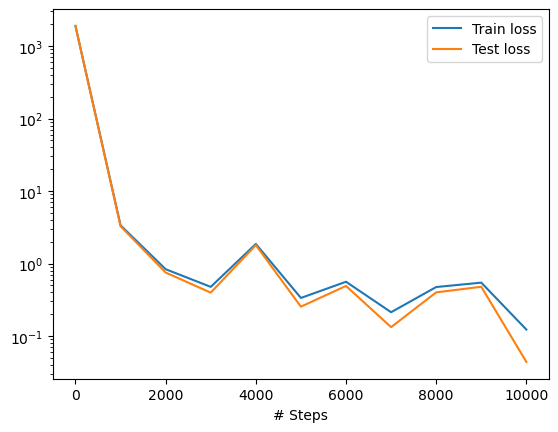

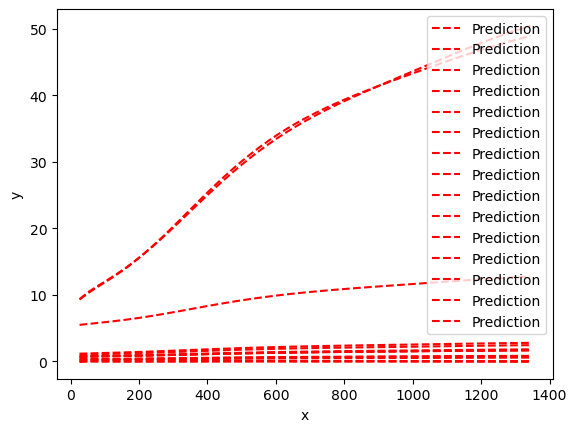

In [26]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [27]:
model.state_dict()

{'external_trainable_variable:0': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.717123>,
 'external_trainable_variable:1': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.28000808>,
 'external_trainable_variable:2': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.6080553>,
 'external_trainable_variable:3': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.35327858>,
 'external_trainable_variable:4': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.35949036>,
 'external_trainable_variable:5': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.14167123>,
 'external_trainable_variable:6': <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.4141297>,
 'denses.0.kernel': <tf.Variable 'fnn/dense/kernel:0' shape=(1, 30) dtype=float32, numpy=
 array([[ 0.00821015, -0.00765151,  0.16034117, -0.29963487, -0.07012183,
         -0.0666461 , -0.00106321,  0.00585792, -0.00204428, -0.34374434,
          0.51421577, -0.30597305,  0.1144396

In [32]:
model.predict(anchors)


array([[-0.0000000e+00,  0.0000000e+00, -0.0000000e+00,  0.0000000e+00,
        -0.0000000e+00,  0.0000000e+00,  0.0000000e+00, -0.0000000e+00,
         0.0000000e+00, -0.0000000e+00,  0.0000000e+00, -0.0000000e+00,
         0.0000000e+00,  0.0000000e+00, -0.0000000e+00],
       [ 4.1920212e-01,  8.3883303e-01,  2.8762442e-01,  2.7450567e-01,
        -2.5126973e-02,  8.7155157e-01,  8.3533007e-01,  3.8759637e-01,
         6.3230767e+00,  8.9732546e-01,  1.2084453e+00,  3.2635715e-02,
         1.4329937e+01,  1.4279184e+01,  1.3809915e+00],
       [ 5.1245219e-01,  1.0250597e+00,  3.5107270e-01,  2.4477065e-01,
        -1.1474186e-02,  1.0578372e+00,  1.0211515e+00,  4.7532916e-01,
         7.7372675e+00,  1.1064678e+00,  1.4815340e+00,  3.4350865e-02,
         2.1873707e+01,  2.2136904e+01,  1.6971452e+00],
       [ 6.8332899e-01,  1.3671435e+00,  4.6839553e-01,  5.5804953e-02,
         4.0406594e-03,  1.3865484e+00,  1.3506449e+00,  6.3236630e-01,
         1.0311738e+01,  1.4697469e+0

In [29]:
test_data = np.genfromtxt('test.dat',
                     skip_header=0,
                     skip_footer=0,
                     names=None,
                     dtype=None,
                     delimiter=' ')
test_data

array([[1.68000000e+02, 4.19202119e-01, 8.38833034e-01, ...,
        1.43299370e+01, 1.42791843e+01, 1.38099146e+00],
       [3.36000000e+02, 5.12452185e-01, 1.02505970e+00, ...,
        2.18737068e+01, 2.21369038e+01, 1.69714522e+00],
       [6.72000000e+02, 6.83328986e-01, 1.36714351e+00, ...,
        3.57502594e+01, 3.61878204e+01, 2.25656819e+00],
       ...,
       [1.26494116e+03, 8.32318783e-01, 1.66452217e+00, ...,
        4.91396866e+01, 4.78673210e+01, 2.75324702e+00],
       [1.29129407e+03, 8.37020159e-01, 1.67449665e+00, ...,
        4.96042557e+01, 4.82425270e+01, 2.77042294e+00],
       [1.31764709e+03, 8.41381431e-01, 1.68389094e+00, ...,
        5.00449142e+01, 4.85978546e+01, 2.78670979e+00]])

In [30]:
columns_names=['Time', 'M_art', 'M_venous', 'M_gills', 'M_lumen', 'M_lumen_2', 'M_viscera', 'M_liver', 'M_kidney', \
                'M_muscle', 'M_skin', 'M_carcass', 'M_storage', 'M_urine', 'M_feces', 'M_blood']
test_df = pd.DataFrame(test_data, columns = columns_names)
test_df

,Time,M_art,M_venous,M_gills,M_lumen,M_lumen_2,M_viscera,M_liver,M_kidney,M_muscle,M_skin,M_carcass,M_storage,M_urine,M_feces,M_blood
0,168.000000,0.419202,0.838833,0.287624,0.274506,-0.025127,0.871552,0.835330,0.387596,6.323077,0.897325,1.208445,0.032636,14.329937,14.279184,1.380991
1,336.000000,0.512452,1.025060,0.351073,0.244771,-0.011474,1.057837,1.021152,0.475329,7.737267,1.106468,1.481534,0.034351,21.873707,22.136904,1.697145
2,672.000000,0.683329,1.367144,0.468396,0.055805,0.004041,1.386548,1.350645,0.632366,10.311738,1.469747,1.976330,0.037970,35.750259,36.187820,2.256568
3,744.000000,0.705900,1.412695,0.483816,0.050711,0.003883,1.431995,1.397112,0.653709,10.658817,1.519138,2.039569,0.037788,37.750664,38.081211,2.332293
4,840.000000,0.731843,1.464808,0.501534,0.049586,0.003521,1.484233,1.450214,0.678221,11.055411,1.575909,2.111880,0.037293,40.085911,40.225040,2.419214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,1212.235352,0.821933,1.642953,0.563142,0.000816,0.007737,1.660444,1.624720,0.760643,12.398962,1.768897,2.373214,0.037452,48.144733,47.061081,2.716455
95,1238.588257,0.827284,1.653994,0.566809,-0.005249,0.008357,1.671408,1.635425,0.765597,12.484052,1.781290,2.390439,0.037534,48.652534,47.473064,2.735233
96,1264.941162,0.832319,1.664522,0.570261,-0.011201,0.008988,1.681906,1.645662,0.770302,12.565774,1.793238,2.407001,0.037600,49.139687,47.867321,2.753247
97,1291.294067,0.837020,1.674497,0.573487,-0.016961,0.009624,1.691898,1.655393,0.774742,12.643784,1.804688,2.422822,0.037649,49.604256,48.242527,2.770423


In [31]:
test_df.to_csv('predictions.csv', sep=',')
